```@meta
CurrentModule = AlgorithmicRecourse 
```

# Models

## Custom models

Instead of ...

### Neural network

In [145]:
# Import libraries.
using Flux, Plots, Random, PlotThemes, Statistics
theme(:juno)

Generate some toy data ....

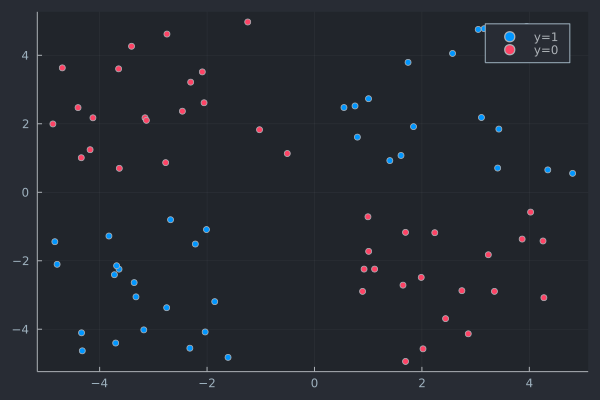

In [146]:
# Number of points to generate.
N = 80
M = round(Int, N / 4)
Random.seed!(1234)

# Generate artificial data.
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
xt1s = Array([[x1s[i] + 0.5; x2s[i] + 0.5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
append!(xt1s, Array([[x1s[i] - 5; x2s[i] - 5] for i = 1:M]))

x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
xt0s = Array([[x1s[i] + 0.5; x2s[i] - 5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
append!(xt0s, Array([[x1s[i] - 5; x2s[i] + 0.5] for i = 1:M]))

# Store all the data for later.
xs = [xt1s; xt0s]
X = reshape(hcat(map(x -> x[1], xs), map(x -> x[2], xs)), (2,80))
ts = [ones(2*M); zeros(2*M)]

# Plot data points.
function plot_data()
    x1 = map(e -> e[1], xt1s)
    y1 = map(e -> e[2], xt1s)
    x2 = map(e -> e[1], xt0s)
    y2 = map(e -> e[2], xt0s)

    Plots.scatter(x1,y1, color=0, clim = (0,1), label="y=1")
    Plots.scatter!(x2,y2, color=1, clim = (0,1), label="y=0")
end

plot_data()

In [147]:
function build_nn(;input_dim=2,n_hidden=32,output_dim=1)
    
    # Params:
    W₁ = input_dim
    b₁ = n_hidden
    W₀ = n_hidden
    b₀ = output_dim
    
    nn = Chain(
        Dense(W₁, b₁, σ),
        Dense(W₀, b₀))  

    return nn

end
nn = build_nn()

Chain(
  Dense(2, 32, σ),                      # 96 parameters
  Dense(32, 1),                         # 33 parameters
)                   # Total: 4 arrays, 129 parameters, 772 bytes.

In [148]:
loss(x, y) = Flux.Losses.logitbinarycrossentropy(nn(x), y)
ps = Flux.params(nn)

Params([Float32[-0.3548387 0.25249097; 0.110254146 0.28800523; … ; -0.41406566 -0.15154399; 0.04102333 0.41145942], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.06597835 0.3264578 … -0.18607129 0.16409278], Float32[0.0]])

In [149]:
data = zip(xs,ts)
first(data,5)
last(data,5)

5-element Vector{Tuple{Vector{Float64}, Float64}}:
 ([-2.7707280197780535, 0.8659694914362743], 0.0)
 ([-2.0556798361596385, 2.6144500379249975], 0.0)
 ([-1.2429117104575864, 4.97298670264245], 0.0)
 ([-3.1295196296580343, 2.101200411422793], 0.0)
 ([-4.177595688278877, 1.2430962187092964], 0.0)

In [150]:
avg_loss(data) = mean(map(d -> loss(d[1],d[2]), data))

avg_loss (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = /var/folders/99/2fj_h1qs3gj3x8nqmpx20mrc0000gq/T/jl_Shdw7q.gif
└ @ Plots /Users/FA31DU/.julia/packages/Plots/Zuo5g/src/animation.jl:114


Plots.AnimatedGif("/var/folders/99/2fj_h1qs3gj3x8nqmpx20mrc0000gq/T/jl_Shdw7q.gif")
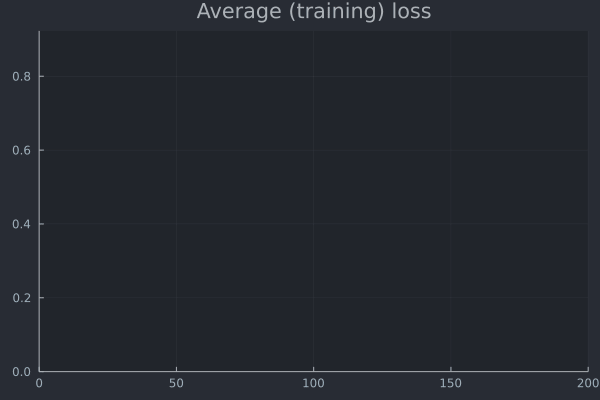

In [151]:
using Flux.Optimise: update!, ADAM
opt = ADAM()
epochs = 200

using Plots
anim = Animation()
plt = plot(ylim=(0,avg_loss(data)), xlim=(0,epochs), legend=false)
avg_l = []

for epoch = 1:epochs
  for d in data
    gs = gradient(params(nn)) do
      l = loss(d...)
    end
    update!(opt, params(nn), gs)
  end
  avg_l = vcat(avg_l,avg_loss(data))
  plot!(plt, avg_l, color=1, title="Average (training) loss")
  frame(anim, plt)
  # @show avg_loss(data)
end

gif(anim)

In [154]:
σ.(nn(X))

1×80 Matrix{Float64}:
 0.996638  0.997983  0.997877  0.987184  …  0.821747  0.949076  0.984273